In [1]:
import numpy as np
import pandas as pd
from pyecharts import Kline, Overlap, Line, Grid, EffectScatter
%matplotlib inline

In [2]:
from LayerModel3 import Point, StdK, Stick, Trend

In [3]:
# 绘图用插值函数
# input: 
#       1 - TmIdx array 
#       2 - Values array
# output: 按x轴查完值的value array
def interpoint(TmIdx_array, V_array):
    global x
    x['TmIdx'].astype('int64')
    print(len(x))
    df_tmp = pd.DataFrame({'V': V_array, 'TmIdx': TmIdx_array})
    df_tmp['TmIdx'].astype('int64')
    df_tmp.to_excel('xx.xlsx')
    df_tmp = df_tmp.merge(x, how='right', left_on='TmIdx', right_on='TmIdx')
    print(len(df_tmp))
    df_tmp.sort_values(['TmIdx'], inplace=True)
    return df_tmp['V'].interpolate().values.tolist()

### Data Import

In [4]:
fn_str = '300328.XSHE-1m.csv'

In [5]:
df = pd.read_csv(fn_str)

#### Data Transform:  from MC

In [6]:
df.head()

,Unnamed: 0,high,open,close,total_turnover,low,volume
0,2019-01-02 09:31:00,6.14,6.14,6.11,348235.0,6.08,56800.0
1,2019-01-02 09:32:00,6.11,6.11,6.11,81100.0,6.09,13300.0
2,2019-01-02 09:33:00,6.13,6.11,6.13,56277.0,6.11,9200.0
3,2019-01-02 09:34:00,6.14,6.13,6.13,79162.0,6.13,12900.0
4,2019-01-02 09:35:00,6.13,6.13,6.12,60047.0,6.12,9800.0


In [7]:
df.columns = ['Time','H', 'O', 'C', 'total_turnover',  'L', 'Vol']
df['TmIdx'] = df.index

In [8]:
df['Tm'] = ''

In [9]:
dt = df[['O', 'H', 'L', 'C', 'TmIdx']].values.tolist()

In [10]:
len(dt)

9600

#### load data from MongoDB

In [4]:
from pymongo import MongoClient, ASCENDING
mc = MongoClient()                  # Mongo连接
dbMinute30 = mc['Trade2019_Minute30']       # 数据库

symbol = '600018'
TmS = '2019-03-01 10:30'
TmE = '2019-04-04 10:30'
monthS = 3
cl = dbMinute30[symbol]
flt = {'month':{'$gte':monthS}}        
dataCursor = cl.find(flt, {'_id':0})
dt = []
i = 0
x_L = []
for d in dataCursor:
    dt.append([d['open'], d['high'], d['low'], d['close'], i])
    x_L.append([d['datetime'], i])
    i += 1   
x = pd.DataFrame(x_L, columns=['Tm', 'TmIdx'])

In [5]:
x.tail()

,Tm,TmIdx
224,2019-04-10 15:00,224
225,2019-04-11 10:00,225
226,2019-04-11 10:30,226
227,2019-04-11 11:00,227
228,2019-04-11 13:00,228


In [41]:
dt[-5:]

[[8.87, 8.87, 8.87, 8.87, 196],
 [8.87, 8.87, 8.87, 8.87, 197],
 [8.87, 8.87, 8.87, 8.87, 198],
 [8.87, 8.87, 8.87, 8.87, 199],
 [8.87, 8.87, 8.87, 8.87, 200]]

###  特征提取

In [5]:
getTV = lambda lv_L: [(stick.start.TmIdx, stick.start.V) for stick in lv_L]
    

def main():
    global dt
    
    for k in dt[1:]:
        #print(k[4], Stick.lv_L[0].drt)
        flag_lv0, flag_lv1, flag_lv2 = 0,0,0
        
        # update crt Lv0 and add new lv0
        flag_lv0 = Stick.lv_L[-1].update(k)  
        
        # update crt Lv1 and add new Lv1
        TrendLv1.lv_L[-1].updateEndP(k)
        if flag_lv0 == 2:
            flag_lv1 = TrendLv1.lv_L[-1].update2()
        elif flag_lv0 == 1:
            flag_lv1 = TrendLv1.lv_L[-1].updatePeakP(k_bar=k)
            
        # update crt Lv2 and add new Lv2
        TrendLv2.lv_L[-1].updateEndP(k)
        if flag_lv1 == 2 or flag_lv1 == 3:
            flag_lv2 = TrendLv2.lv_L[-1].update2()
        elif flag_lv1 == 1:
            flag_lv2 = TrendLv2.lv_L[-1].updatePeakP(k_bar=k)
        
    return None

In [6]:
Stick('init', k_bar=dt[0])
lv0_L = Stick.lv_L

TrendLv1 = type('TrendLv1', (Trend,), {'lv_L':[], 'main_list':Stick.lv_L, 'level':'TrendLv1'}) 
TrendLv1('init', k_bar=dt[0], mp=[0])
lv1_L = TrendLv1.lv_L

TrendLv2 = type('TrendLv2', (Trend,), {'lv_L':[], 'main_list':TrendLv1.lv_L, 'level':'TrendLv2'}) 
TrendLv2('init', k_bar=dt[0], mp=[0])
lv2_L = TrendLv2.lv_L

main()

In [7]:
tm, v, stick_drt = [], [], []
for stick in lv0_L:
    tm.append(stick.start.TmIdx)
    v.append(stick.start.V)
    #stick.print_()
    #print('')

In [8]:
tm1,v1 = [], []
for lv1 in lv1_L:
    tm1.append(lv1.start.TmIdx)
    v1.append(lv1.start.V)
    #lv1.print_()

In [9]:
tm2,v2 = [], []
for lv2 in lv2_L:
    tm2.append(lv2.start.TmIdx)
    v2.append(lv2.start.V)

In [18]:
tm3 = [xx[0] for xx in x[0]]
v3 = [xx[1] for xx in x[0]]
v4 = [xx[2] for xx in x[0]]

In [20]:
vN = [xx for xx in x[1]]
df_ana_vN = pd.DataFrame(vN)
df_ana_vN.to_excel('xx.xlsx')

### Analysis

In [32]:
df_ana = pd.DataFrame({'V': v1, 'TmIdx': tm1})
df_ana.to_excel('xx.xlsx')

In [33]:
df_ana['tm_diff'] = df_ana['TmIdx'].diff(1)

In [34]:
df_ana['v_diff'] = df_ana['V'].diff(1)

In [45]:
df_ana['v_diff_cate'] = pd.cut(df_ana['v_diff'],[-1000000,0,1000000], labels=['Neg', 'Pos'])

In [50]:
df_ana.loc[df_ana.v_diff_cate=='Pos','tm_diff'].describe()

count    240.00000
mean      55.65000
std       46.14923
min        4.00000
25%       22.75000
50%       40.00000
75%       73.50000
max      242.00000
Name: tm_diff, dtype: float64

In [51]:
df_ana.loc[df_ana.v_diff_cate=='Neg','tm_diff'].describe()

count    240.000000
mean      49.995833
std       43.349750
min        2.000000
25%       23.000000
50%       40.000000
75%       60.000000
max      274.000000
Name: tm_diff, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B6C0FC02B0>,
      dtype=object)

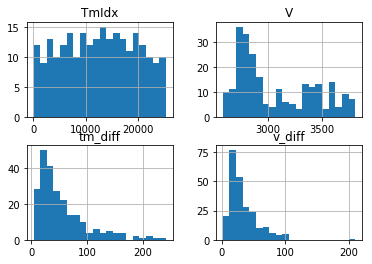

In [48]:
df_ana[df_ana.v_diff_cate == 'Pos'].hist(bins=20)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B6C47D25F8>,
      dtype=object)

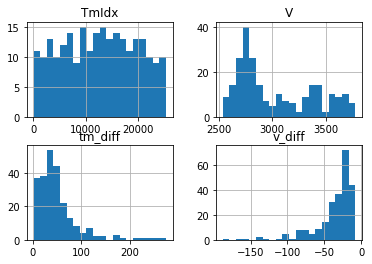

In [49]:
df_ana[df_ana.v_diff_cate == 'Neg'].hist(bins=20)

In [20]:
df_ana_ss_pct = pd.DataFrame({'ss_pct': v3, 'pair_count':v4,  'TmIdx': tm3})
df_ana_ss_pct.to_excel('xx.xlsx')

In [30]:
ana = pd.DataFrame()

In [31]:
ana['count'] = df_ana_ss_pct.groupby('pair_count')['ss_pct'].count()
ana['mean'] = df_ana_ss_pct.groupby('pair_count')['ss_pct'].mean()
ana['95%'] = df_ana_ss_pct.groupby('pair_count')['ss_pct'].quantile(0.95)
ana['90%'] = df_ana_ss_pct.groupby('pair_count')['ss_pct'].quantile(0.90)
ana['80%'] = df_ana_ss_pct.groupby('pair_count')['ss_pct'].quantile(0.80)
ana['70%'] = df_ana_ss_pct.groupby('pair_count')['ss_pct'].quantile(0.70)

In [33]:
ana

,count,mean,95%,90%,80%,70%
pair_count,,,,,,
1,205,67.613417,86.189189,82.352941,76.470588,72.972973
2,830,61.095909,75.000000,70.602582,66.666667,65.217391
3,685,58.839556,70.833333,68.421053,63.414634,61.952941
4,464,59.537214,71.186441,68.302348,64.285714,61.702128
5,289,59.753522,68.012868,67.058824,64.958838,63.321101
6,150,59.586245,65.853659,65.000000,63.218391,62.608696
7,75,59.449593,65.553164,64.705882,62.962963,62.475248
8,46,58.411610,64.939512,63.289561,62.406015,60.144815
9,29,57.895956,63.902342,60.844444,59.755556,59.200000


### Drawing

In [22]:
# X-axis-data
x_idx = [k[4] for k in dt]
#x = df[['TmIdx','Tm']]

In [32]:
oringe_dt = [[k[0], k[3], k[2], k[1]] for k in dt]
dt_line = interpoint(tm,v)
dt_lv1_line = interpoint(tm1, v1)
dt_lv2_line = interpoint(tm2, v2)

196
196
196
196
196
196


In [33]:
kline = Kline('Test1901!')
# 开收低高
oringe_dt = [[k[0], k[3], k[2], k[1]] for k in dt]
kline.add('xx',[k[4] for k in dt], [k[0:4] for k in oringe_dt]
         ,is_datazoom_show=True
         #,datazoom_xaxis_index=[0,1]
         )
#kline.print_echarts_options()
#kline.render() 生成本地html

In [49]:
line = Line('stick')
line.add('xxx', [k[4] for k in dt], dt_line
        ,is_datazoom_show=True
        ,yaxis_min =6
        )
line

AssertionError: 

In [47]:
line_lv1 = Line('Trend')
line_lv1.add('xxx', [k[4] for k in dt], dt_lv1_line \
        ,is_datazoom_show=True \
        ,line_color = 'green' \
        ,yaxis_min = 6
        )
#line_lv1

AssertionError: 

In [48]:
line_lv2 = Line('Trend')
line_lv2.add('xxx', [k[4] for k in dt], dt_lv2_line
        ,is_datazoom_show=True
        ,line_color = 'blue'
        )
#line_lv1

AssertionError: 

In [42]:
overlap = Overlap()
overlap.add(kline)
overlap.add(line)
#overlap.add(line_lv1)
#overlap.add(line_lv2)
overlap

In [25]:
l2 = [[x.start.TmIdx,(x.peak.V - x.start.V)/x.start.V] for x in lv2_L]

In [26]:
r_df = pd.DataFrame(l2)
r_df.to_csv('xx.csv')

In [28]:
te_markdown = [(s.end.TmIdx, s.peak.V) for s in lv2_L if s.drt == 1]
markdown = [x for x in zip(*te_markdown) ]
te_markup = [(s.end.TmIdx, s.peak.V) for s in lv2_L if s.drt == -1]
markup = [x for x in zip(*te_markup) ]

In [29]:
es2_up = EffectScatter("End Marks")
es2_up.add( "",
    markup[0],
    markup[1],
    symbol_size=4,
    line_color = '#f9713c',
    effect_scale=0,
    effect_period=0,
    symbol="pin")
es2_down = EffectScatter("End Marks")
es2_down.add( "",
    markdown[0],
    markdown[1],
    symbol_size=4,
    line_color = 'green',
    effect_scale=0,
    effect_period=0,
    symbol="pin")

In [30]:
overlap = Overlap()
#overlap.add(kline)
#overlap.add(line)
overlap.add(line_lv1)
overlap.add(line_lv2)
overlap.add(es2_up)
overlap.add(es2_down)
overlap

In [28]:
overlap.render(width= '1280')

In [50]:
lll = [0,1,2]
for i in lll:
    if i < 150:
        ii = i +10
        if ii not in lll:
            lll.append(ii)
    print(i)

0
1
2
10
11
12
20
21
22
30
31
32
40
41
42
50
51
52
60
61
62
70
71
72
80
81
82
90
91
92
100
101
102
110
111
112
120
121
122
130
131
132
140
141
142
150
151
152
